In [1]:
import sys
sys.path.append('/mnt/disk05/note/workspaces/duxx')
from feature_selector import FeatureSelector
from unity import init_pkg as ini
from unity.eda_func import EdaFunc as edf
from unity.fea_eda_func import FeaEdaFunc as fef
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve
import os
import json
import datetime
import gc
import scorecardpy as sc
from imblearn.over_sampling import SMOTE
# import pickle
# import joblib
# import pandas_profiling

% matplotlib inline

In [2]:
bdbank = ini.pd.read_pickle('data/bd/bdbank.pkl')
bdtag = ini.pd.read_csv('data/tag/bd_tag_avli.csv')
bdbank=bdbank[bdbank['TRANSACTION_TYPE']=='apply']
bdtag['tag'] = 0
bdtag.loc[bdtag['ovdue_days']>30,'tag'] = 1
bdtag = bdtag.groupby('cert_no')['tag'].max().reset_index(name='tag')
bdbank = bdbank.sort_values('CREATED_DATE',ascending=0).drop_duplicates('ID_CARD_NO',keep='last')
bdbank = bdbank.dropna(subset=['ID','ID_CARD_NO'])
bdbank = bdbank.rename({'ID_CARD_NO':'cert_no'},axis=1)
bdmain = bdbank.merge(bdtag,on='cert_no')
del bdbank,bdtag

In [3]:
# 加入伪标签
# bdmain = ini.pd.read_csv('data/bd/merge_with_fake.csv')

In [4]:
# bdmain=bdmain.drop(['ovdue_days','unionLoanUsed' 'idpicture0' 'photowithidcard' 'orderId' 'livingPhoto'],axis=1)

# 一、数据清洗

## 1.1 剔除单一值、缺失>0.7、相关性>0.7

In [5]:
drop_feas = {'ID','BANK_CARD_NO','MOBILE_NO','TRANSACTION_ID','CUST_NAME','ORDER_NO','reasonMsg','TRANSACTION_TYPE','zxSex',
             'TRANSACTION_ID','BANK_CARD_NO','UPDATED_DATE','zxDomicile','zxPermanentAddress'}

bdmain = bdmain.replace([-9999,'-9999'],ini.np.nan)

In [6]:
fs = FeatureSelector(data=bdmain.drop('tag',axis=1),labels=bdmain['tag'])
fs.identify_missing(0.7)
fs.identify_single_unique()
fs.identify_collinear(0.7)
fs_drop = fs.check_removal()

38 features with greater than 0.70 missing values.

7 features with a single unique value.

0 features with a correlation magnitude greater than 0.70.

Total of 45 features identified for removal


In [7]:
drop_feas = drop_feas | set(fs_drop)

In [8]:
bdmain.head()

,ID,CUST_NAME,cert_no,MOBILE_NO,BANK_CARD_NO,CREATED_DATE,UPDATED_DATE,TRANSACTION_TYPE,TRANSACTION_ID,ORDER_NO,INIT_AMOUNT,ANNUAL_INT_RATE,CASH_AMOUNT,AFTER_LMT,BEFORE_LMT,PRE_A_CUST_SEG,zxCreditCardDelqStatus30To60Days,zxHouseFundPayStatus,zxLoanRcyDelqDate,zxDomicile,zx1MthDelqMaxAmt,risCode,zxCreditCardAccuDelqCnt,zxCreditCardDelqStatus90To180Days,zxAccountCnt,zxRcy24MCreCardMaxDelqPeriod,zxHouseFundPayLastMonth,zxCreditCardDelqStatus30Dayyues,r21P12FinallyInterest,zxBadBebtsBalance,zxMaxMonths,zxMaxCreditAmt,zxLoanBalanceAmt,phoneNormalScoreExp3,zxCommerHouseLoanBlance,zxGuaranteeCnt,zxMaxUpdated,zxRcy6MCreCardQueryCompanyCnt,zxCareer,preACustSeg,zxLoanDelqStatus30Dayyues,zxFirstLoanMonth,zxBlanceShouldPayAmt,zxRcy12MCreCardMaxDelqPeriod,zxRestDisposalCnt,zxCreCardUseCreditRate,zxRcy3MCreCardQueryCnt,zxCreCardMaxMonthsCnt,reasonCode,zxRcy6MCreCardQueryCnt,zxCreCardStatus4,zxCreCardStatus5,zxCreCardStatus2,zxCreCardStatus3,zxPermanentAddress,zxLoanCompanyBalCnt,zxWarrantLoanRate1,creditValidityDays,taxMonthlyIncomeSection,zxFirstCreCardDate,zxCreCardStatus1,zxLoanRcyUpdateDate,zxRcy6MLoanQueryCnt,zxWarrantLoanType,zxCreCardDelqAccoutCnt,zxRcy24MAcctMaxDelqPeriod,zxIssuBankCnt,zxLoanDelqStatus6To12Months,zxDelqCnt,zxRcy1MLoanQueryCompanyCnt,initialAmount,zxCreCardNowShouldPayAmt,zxFirstLoanDate,zxLoanDelqStatus60To90Days,reasonMsg,zxRcy1MCreCardQueryCnt,zxRcy6MAvgUseCreditAmt,zxCreditCardRcyUpdateDate,zxRcy24MCreCardTotalDelqCnt,zxEducation,zxRcyQueryDate,dxmAScore,holmesAgentScore,zxHouseFundCompanyRate,prcidNormalScoreExp3,zxLoanDelqStatus90To180Days,zxHouseLoan1MAvgPayAmt,zxRcy3MCreCardQueryCompanyCnt,zxCreditCardDelqStatus6To12Months,zxBadBebtsCnt,zxPersonalLoanCnt,zxCreditBal,zxSex,zxAccountNowTotalDelqAmt,zxHouseFundMonthPayAmt,zxHouseFundSelfRate,zxLoanBalCnt,zxMinCreditAmt,zxTotalCreditAmt,zxMaritalStatus,zxRcy3MLoanQueryCompanyCnt,zxWarrantLoanCnt,zxCreditAvgLimit,blackListType,zxCreditCardDelqStatus60To90Days,zxRcy6MLoanQueryCompanyCnt,zxRcy3MLoanQueryCnt,zxUseCreditAmt,zxCreCardAcctNowTotalDelqAmt,zxCreditRetCode,zxLoanDelqStatus30To60Days,zxRcy1MLoanQueryCnt,zxRcy1MCreCardQueryCompanyCnt,zxHouseFundRecordUpdate,zxWarrantLoanTypeUnnormal,zxHouseFundMonthShouldPayAmt,zxRcy6MCreCardMaxDelqPeriod,zxCreditCardDelqStatus24Months,zxRcy6MAvgPayAmt,bidNormalScoreExp3,zxCreCardDelqMaxAmt,zxCreditCardRcyDelqDate,holmesBlackScore,dailyInterestRate,dailyPenaltyRate,unionLoanUsed,orderId,cashAmount,term,compreAnnualInterestRate,usedTotalLimit,ifLiving,ocrNation,ocrExpdate,ocrSignOrg,photowithidcard,ifIdPicture,idpicture1,idpicture0,livingPhoto,tag
0,99c296b272d77d0b017300cc10382993,李加波,371329198911082714,13668690660,6217002290021005953,2020-06-29 23:57:20,2020-06-29 23:57:20,apply,1160951258133627348,2202006294440686705923952492_44584117954364638...,11000.0,0.0,NaN,NaN,NaN,NaN,N,NaN,20170901,山东省临沭县大兴镇李格庄409号,1602,10000,0,N,2,0,NaN,N,5.0000,NaN,1,15057,228861,NaN,0,NaN,2019-06-12,0,商业、服务业人员,B,C,2016-03,2920,0,NaN,0.8137,0,NaN,NaN,0,正常,NaN,NaN,正常,山东省临沂市,5,NaN,30,NaN,2019-02-20,正常,2020-06-20,1,NaN,NaN,0,1,N,1,0,1100000,1144,2016-03-12,N,NaN,0,12206,2020-06-08,0,未知,2020-06-29 23:56:37,553,0,NaN,NaN,N,1616,0,N,NaN,0,9595,男,0,NaN,NaN,9,15057,15000,未婚,0,NaN,15000,NaN,N,1,0,9595,0,0000,N,0,0,NaN,NaN,0,0,N,2755,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,99c296b272d77d0b017300c59a692920,刘颜树,522728199509140663,13765441464,6228481198806286374,2020-06-29 23:50:16,2020-06-29 23:50:16,apply,901896174999117926,2202006294458411795436463709_44584117954364637...,24500.0,0.0,NaN,NaN,NaN,NaN,N,缴交,NaN,贵州省贵阳市云岩区黔灵镇茶店小学61号,0,10000,0,N,1,0,2020-05,N,5.0000,NaN,0,9000,16761,NaN,0,NaN,2020-05-20,0,NaN,B,C,2015-11,502,0,NaN,0.4652,0,NaN,NaN,0,正常,提前结清,NaN,正常,NaN,2,NaN,30,NaN,2019-05-06,正常,2020-06-15,0,NaN,NaN,0,1,N,0,0,2450000,669,2015-11-03,N,NaN,0,4187,2020-06-02,0,未知,2020-06-25 02:33:33,704,0,5%,NaN,N,NaN,0,N,NaN,0,5104,女,0,168,5%,6,9000,9000,未婚,0,NaN,9000,NaN,N,0,0,5104,0,0000,N,0,0,2020-05-01,NaN,0,0,N,524,

In [9]:
bdmain = bdmain.drop(drop_feas,axis=1)

In [10]:
# bdmain = bdmain.drop('CREATED_DATE',axis=1)

## 1.2 异常值处理

In [11]:
# bdmain = bdmain.replace([-9999,'-9999'],ini.np.nan)

## 1.3 划分数据集

In [12]:
train_x,test_x,train_y,test_y = train_test_split(bdmain,bdmain['tag'],test_size=0.3,shuffle=True,random_state=123)

In [13]:
train_x.shape

(26420, 86)

In [14]:
train_x['tag'].value_counts()

0    26104
1      316
Name: tag, dtype: int64

In [15]:
test_x['tag'].value_counts()

0    11188
1      136
Name: tag, dtype: int64

# 二、特征工程

## 2.1 日期、百分比、地址特征处理

### 2.1.1 日期特征衍生

In [16]:
date_feas = list(train_x.loc[:,train_x.columns.str.contains('Date|LastMonth|DATE|FirstLoan|Update')].columns)

In [17]:
date_feas

['CREATED_DATE',
 'zxHouseFundPayLastMonth',
 'zxMaxUpdated',
 'zxFirstLoanMonth',
 'zxFirstCreCardDate',
 'zxLoanRcyUpdateDate',
 'zxFirstLoanDate',
 'zxCreditCardRcyUpdateDate',
 'zxRcyQueryDate',
 'zxHouseFundRecordUpdate',
 'zxCreditCardRcyDelqDate']

In [18]:
train_x['zxHouseFundPayLastMonth'] = train_x['zxHouseFundPayLastMonth'].replace('0002-12',ini.np.nan)
test_x['zxHouseFundPayLastMonth'] = test_x['zxHouseFundPayLastMonth'].replace('0002-12',ini.np.nan)
train_x.loc[:,date_feas] = train_x[date_feas].astype('datetime64[ns]')
test_x.loc[:,date_feas] = test_x[date_feas].astype('datetime64[ns]')

In [19]:
for c in date_feas[:-1]:
    train_x[f'{c}_diff_londt'] = abs((train_x['CREATED_DATE'] - train_x[c]).dt.days)
    test_x[f'{c}_diff_londt']  = abs((test_x['CREATED_DATE'] - test_x[c]).dt.days)

In [20]:
train_x = train_x.drop(date_feas,axis=1)
test_x = test_x.drop(date_feas,axis=1)

### 2.1.2 比例特征处理

In [21]:
train_x['zxHouseFundCompanyRate'] = train_x['zxHouseFundCompanyRate'].str.extract('(\d+)').astype(float)/100
train_x['zxHouseFundSelfRate'] = train_x['zxHouseFundSelfRate'].str.extract('(\d+)').astype(float)/100
test_x['zxHouseFundCompanyRate'] = test_x['zxHouseFundCompanyRate'].str.extract('(\d+)').astype(float)/100
test_x['zxHouseFundSelfRate'] = test_x['zxHouseFundSelfRate'].str.extract('(\d+)').astype(float)/100

### 2.1.3 地址特征处理

In [22]:
train_x = fef.build_cert_refer_feas(train_x,cert_cols='cert_no')
test_x = fef.build_cert_refer_feas(test_x,cert_cols='cert_no')

## 2.2 类别特征处理

In [24]:
def bin_group_single(df, col, target):
    """
    单个特征iv,woe
    """
    regroup = df.groupby([col])['tag'].agg(['count','sum']).replace(0,0.0001)\
                .rename({'sum':'bad'},axis=1)\
                .assign(variable=col,
                        count_distr = lambda x:x['count']/sum(x['count']),
                        good=lambda x:x['count']-x['bad'],
                        badprob = lambda x:x['bad']/x['count'],
                        DistrBad = lambda x:x['good']/sum(x['good']),
                        DistrGood = lambda x:x['bad']/sum(x['bad']),
                        woe = lambda x:ini.np.log(x['DistrBad']/x['DistrGood']),
                        bin_iv = lambda x:(x['DistrBad']-x['DistrGood'])*x['woe'],
                        total_iv = lambda x:sum(x.bin_iv))
    regroup.reset_index(level=0,inplace=True)
    return regroup

def bin_group(df, cols, target,missing=True):
    """
    """
    dfc = df.copy()
    bin_df_dicts = {}
    if missing: dfc.loc[:,cols] = dfc.fillna('missing')
    for c in cols:
        bin_df = bin_group_single(dfc,c,target)
        bin_df_dicts[c] = bin_df
    return bin_df_dicts

def badrate_ply(df,cols, bin_df_dicts,missing=True):
    """
    badrate编码转化
    """
    if missing: df.loc[:,cols] = df.fillna('missing')
    bin_badp_dicts = {c:dict(zip(bin_df_dicts[c][c],bin_df_dicts[c]['badprob'])) for c in cols}
    df.replace(bin_badp_dicts,inplace=True)
    return df

def calc_psi(train_bin_dicts,test_bin_dicts):
    """
    根据分箱后的结果计算PSI
    test_bin_dicts 为woe后的结果                                                                                                               
    """
    psi_dict = {}
    for k,te in test_bin_dicts.items():
        if 'woe' in k:
            k = k.split('_woe')[0]                                 
            te = te.rename({'%s_woe' % k:k},axis=1).set_index(k)
            tr = train_bin_dicts[k].rename({'woe':k},axis=1).set_index(k)
        else:
            te = te.set_index(k)
            tr = train_bin_dicts[k].set_index(k)
        pair = ini.pd.concat([te['badprob'],tr['badprob']],axis=1,keys=['test','train'])
        psi = sum(((pair['test']-pair['train'])*(ini.np.log(pair['test']/pair['train']))).dropna())
        psi_dict[k] = psi
    return psi_dict

In [25]:
train_x = train_x.loc[:,train_x.columns.str.contains('zx|tag')]
test_x = test_x.loc[:,test_x.columns.str.contains('zx|tag')]

In [26]:
cat_feas = set(train_x.loc[:,train_x.columns.str.contains('Status|Type|Code|Sex|Seg|LoanUse|Section|ocr|Edu|Career|Mari')].columns)

In [27]:
cat_feas_info = edf.get_features_type(train_x[cat_feas])['cat_feas']

In [28]:
cat_feas_info

zxLoanDelqStatus60To90Days           14
zxCreditCardDelqStatus30To60Days     13
zxCreditCardDelqStatus90To180Days    13
zxHouseFundPayStatus                  4
zxLoanDelqStatus30Dayyues             6
zxCreditCardDelqStatus6To12Months    13
zxEducation                           8
zxMaritalStatus                       5
zxCreCardStatus1                      4
zxCreCardStatus3                      3
zxCreCardStatus5                      6
zxLoanDelqStatus6To12Months          14
zxLoanDelqStatus90To180Days          14
zxCreCardStatus4                      4
zxCreditCardDelqStatus60To90Days     13
zxCreditCardDelqStatus30Dayyues       7
zxLoanDelqStatus30To60Days           14
zxCareer                             10
zxCreditCardDelqStatus24Months       13
dtype: int64

In [29]:
bdmain.shape

(37744, 86)

* <font color=red face=仿宋 size=4>lightgbm测试</font>

In [ ]:
# train_x.loc[:,cat_feas_info.index] = train_x.astype('category')
# test_x.loc[:,cat_feas_info.index] = test_x.astype('category')

# obj_feas = train_x.select_dtypes(include=['object','int']).columns
# train_x.loc[:,obj_feas] = train_x[obj_feas].astype(float)
# test_x.loc[:,obj_feas] = test_x[obj_feas].astype(float)

# from lightgbm import LGBMClassifier
# lgbc = LGBMClassifier(random_state=123,is_unbalanced=True)
# lgbc.fit(train_x.drop('tag',axis=1),train_y)

# predict_train_y = lgbc.predict_proba(train_x.drop('tag',axis=1))[:,1]
# print(roc_auc_score(train_y,predict_train_y))
# predict_train_y = lgbc.predict_proba(test_x.drop('tag',axis=1))[:,1]
# print(roc_auc_score(test_y,predict_train_y))

### 2.2.1 类别  < 4 的特征直接label_encode

In [30]:
labelencode_feas = cat_feas_info[cat_feas_info < 4].index

In [31]:
for f in labelencode_feas:
    label_trans = LabelEncoder()
    label_trans.fit(train_x[f])
    train_x[f] = label_trans.transform(train_x[f])
    test_x[f] = label_trans.transform(test_x[f])

In [32]:
lab_bin_dicts = bin_group(train_x,labelencode_feas,'tag')

### 2.2.2 类别 >= 4 并且<= 8 的直接分箱

In [33]:
woeenc_feas = cat_feas_info[(cat_feas_info >= 4) & (cat_feas_info <= 8)].index

In [34]:
woeenc_feas

Index(['zxHouseFundPayStatus', 'zxLoanDelqStatus30Dayyues', 'zxEducation',
       'zxMaritalStatus', 'zxCreCardStatus1', 'zxCreCardStatus5',
       'zxCreCardStatus4', 'zxCreditCardDelqStatus30Dayyues'],
      dtype='object')

In [35]:
# badp_bin_dicts = bin_group(train_x,badencode_feas,'tag')
# train_x = badrate_ply(train_x,badencode_feas,badp_bin_dicts)
# test_x = badrate_ply(test_x,badencode_feas,badp_bin_dicts)
woeenc_bin_dicts = bin_group(train_x,woeenc_feas,'tag')

In [36]:
adj_cat_feas = ['zxLoanDelqStatus30Dayyues']
adj_cat_bin = {aj:woeenc_bin_dicts[aj] for aj in adj_cat_feas}

In [38]:
adj_cat_bin['zxLoanDelqStatus30Dayyues']

,zxLoanDelqStatus30Dayyues,count,bad,variable,count_distr,good,badprob,DistrBad,DistrGood,woe,bin_iv,total_iv
0,*,14,0.0001,zxLoanDelqStatus30Dayyues,0.000530,13.9999,0.000007,0.000536,3.164554e-07,7.435290,0.003985,0.030893
1,1,78,1.0000,zxLoanDelqStatus30Dayyues,0.002952,77.0000,0.012821,0.002950,3.164554e-03,-0.070295,0.000015,0.030893
2,2,1,0.0001,zxLoanDelqStatus30Dayyues,0.000038,0.9999,0.000100,0.000038,3.164554e-07,4.796140,0.000182,0.030893
3,C,25638,312.0000,zxLoanDelqStatus30Dayyues,0.970401,25326.0000,0.012169,0.970196,9.873408e-01,-0.017517,0.000300,0.030893
4,N,653,3.0000,zxLoanDelqStatus30Dayyues,0.024716,650.0000,0.004594,0.024900,9.493662e-03,0.964259,0.014856,0.030893
5,missing,36,0.0001,zxLoanDelqStatus30Dayyues,0.001363,35.9999,0.000003,0.001379,3.164554e-07,8.379756,0.011554,0.030893


In [40]:
adj_cat_bin['zxLoanDelqStatus30Dayyues'].loc[7] = ['3',0,0.0001,'zxLoanDelqStatus30Dayyues',0,1.9999,0.0001,0.000958,7.661571554935121e-05,0,0,0.026033]
adj_cat_bin['zxLoanDelqStatus30Dayyues'].loc[8] = ['D',0,0.0001,'zxLoanDelqStatus30Dayyues',0,1.9999,0.0001,0.000958,7.661571554935121e-05,0,0,0.026033]
adj_cat_bin['zxLoanDelqStatus30Dayyues'].loc[9] = ['7',0,0.9999,'zxLoanDelqStatus30Dayyues',0,0.0001,0.9999,0.007777,3.830977326333877e-09,0,0,0.026033]
woeenc_bin_dicts.update(adj_cat_bin)

### 2.2.3 类别 > 8 的特征badrate_encode

In [41]:
badenc_feas = cat_feas_info[cat_feas_info > 8].index
badp_bin_dicts = bin_group(train_x,badenc_feas,'tag')
train_x = badrate_ply(train_x,badenc_feas,badp_bin_dicts)
test_x = badrate_ply(test_x,badenc_feas,badp_bin_dicts)

In [42]:
# break

In [43]:
lab_bin_dicts

{'zxCreCardStatus3':    zxCreCardStatus3  count       bad          variable  count_distr  \
 0                 0  25613  308.0000  zxCreCardStatus3     0.969455   
 1                 1    782    8.0000  zxCreCardStatus3     0.029599   
 2                 2     25    0.0001  zxCreCardStatus3     0.000946   
 
          good   badprob  DistrBad     DistrGood       woe    bin_iv  total_iv  
 0  25305.0000  0.012025  0.969392  9.746832e-01 -0.005444  0.000029  0.008387  
 1    774.0000  0.010230  0.029651  2.531645e-02  0.158029  0.000685  0.008387  
 2     24.9999  0.000004  0.000958  3.164556e-07  8.015111  0.007674  0.008387  }

In [44]:
woeenc_bin_dicts['zxCreCardStatus1']

,zxCreCardStatus1,count,bad,variable,count_distr,good,badprob,DistrBad,DistrGood,woe,bin_iv,total_iv
0,missing,2057,30,zxCreCardStatus1,0.077858,2027,0.014584,0.077651,0.094937,-0.200987,0.003474,0.004378
1,未激活,285,3,zxCreCardStatus1,0.010787,282,0.010526,0.010803,0.009494,0.129193,0.000169,0.004378
2,正常,23672,279,zxCreCardStatus1,0.895988,23393,0.011786,0.896146,0.882911,0.014879,0.000197,0.004378
3,销户,406,4,zxCreCardStatus1,0.015367,402,0.009852,0.015400,0.012658,0.196056,0.000538,0.004378


## 2.3 连续特征分箱

In [45]:
ext_cat_feas = set(cat_feas_info[cat_feas_info <= 8].index)

In [46]:
num_feas = list(set(train_x.columns)-ext_cat_feas - {'tag'})

In [47]:
train_x.loc[:,num_feas] = train_x[num_feas].astype(float)
test_x.loc[:,num_feas] = test_x[num_feas].astype(float)

In [48]:
num_feas_info = edf.get_features_type(train_x[num_feas])['num_feas']

In [49]:
# train_x.to_pickle('train_x.pkl')

In [50]:
rf_bin_dicts = sc.woebin(train_x,y='tag',x=num_feas,method='tree',bin_num_limit=6,count_distr_limit=0.01)

[INFO] creating woe binning ...
Binning on 26420 rows and 67 columns in 00:00:13


In [52]:
rf_bin_dicts['zx1MthDelqMaxAmt']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,zx1MthDelqMaxAmt,"[-inf,1500.0)",23327,0.882930,23048,279,0.011960,-0.000021,3.845716e-10,0.031955,1500.0,False
1,zx1MthDelqMaxAmt,"[1500.0,2000.0)",531,0.020098,529,2,0.003766,-1.163740,1.621785e-02,0.031955,2000.0,False
2,zx1MthDelqMaxAmt,"[2000.0,2500.0)",456,0.017260,450,6,0.013158,0.096614,1.689388e-04,0.031955,2500.0,False
3,zx1MthDelqMaxAmt,"[2500.0,3000.0)",332,0.012566,323,9,0.027108,0.833674,1.342834e-02,0.031955,3000.0,False
4,zx1MthDelqMaxAmt,"[3000.0,5000.0)",767,0.029031,760,7,0.009126,-0.273307,1.902874e-03,0.031955,5000.0,False
5,zx1MthDelqMaxAmt,"[5000.0,inf)",1007,0.038115,994,13,0.012910,0.077314,2.366409e-04,0.031955,inf,False


## 2.4 按照IV值与badprob单调性筛选特征

In [53]:
all_bin_df_dicts = {**rf_bin_dicts,**lab_bin_dicts,**woeenc_bin_dicts}
feas_info = fef.filter_fea(all_bin_df_dicts)
feas_info = fef.filter_fea(rf_bin_dicts)

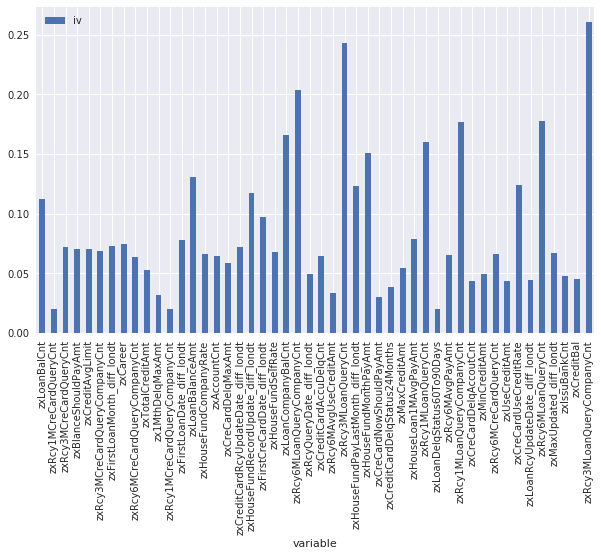

In [54]:
sele_feas = set(feas_info[feas_info['iv'] > 0.02].sort_values('iv',ascending=False).index)
feas_info.reindex(sele_feas).plot.bar(figsize=(10,6))

In [71]:
train_x = train_x[sele_feas]
test_x = test_x[sele_feas]

## 2.5 特征woe编码

In [124]:
# test_x = test_x.fillna('missing')

In [238]:
train_x_woe = sc.woebin_ply(train_x,rf_bin_dicts)
test_x_woe = sc.woebin_ply(test_x,rf_bin_dicts)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [ ]:
labsele_feas = sele_feas & set(labelencode_feas)
train_x_woe = sc.lab_woe_ply(train_x_woe,labsele_feas,lab_bin_dicts)
test_x_woe = sc.lab_woe_ply(test_x_woe,labsele_feas,lab_bin_dicts)

In [ ]:
woesele_feas = sele_feas & set(woeenc_feas)
train_x_woe = sc.lab_woe_ply(train_x_woe,woesele_feas,woeenc_bin_dicts)
test_x_woe = sc.lab_woe_ply(test_x_woe,woesele_feas,woeenc_bin_dicts)

In [ ]:
train_x_woe = train_x_woe.astype(float)
test_x_woe = test_x_woe.astype(float)

## 2.6 相关性筛选

In [ ]:
# fs = FeatureSelector(train_x_woe,labels=train_y)
# fs.identify_collinear(0.7)
# fs.identify_single_unique()
# fs_drop_feas = fs.check_removal()
# train_x_woe.drop(fs_drop_feas,axis=1,inplace=True)
# test_x_woe.drop(fs_drop_feas,axis=1,inplace=True)

In [ ]:
all_bin_df_dicts['zxHouseFundMonthPayAmt']

In [ ]:
all_bin_df_dicts['zxHouseFundPayStatus']

## 2.7 逐步回归筛选特征

In [ ]:
# step_drop_feas,res = fef.step_logit(train_x_woe,train_y)
# train_x_woe.drop(step_drop_feas,axis=1,inplace=True)
# test_x_woe.drop(step_drop_feas,axis=1,inplace=True)

## 2.8 lightgbm筛选特征（回选）

In [ ]:
# lightgbm_feas = {'zxRcy3MLoanQueryCnt','zxCreCardUseCreditRate','zxHouseFundPayStatus','zxRcy6MLoanQueryCompanyCnt','zxLoanCompanyBalCnt',
#                 'zxHouseFundMonthPayAmt','zxLoanBalCnt','zxLoanBalanceAmt','zxCreditCardAccuDelqCnt','zxLoanRcyDelqDate_diff_londt',
#                  'zxFirstLoanDate_diff_londt','zxFirstLoanMonth_diff_londt','zxCreditCardDelqStatus6To12Months'}
# lightgbm_feas = {f+'_woe' for f in lightgbm_feas if f in num_feas}
# step_drop_feas = set(step_drop_feas)-lightgbm_feas
# train_x_woe.drop(step_drop_feas,axis=1,inplace=True)
# test_x_woe.drop(step_drop_feas,axis=1,inplace=True)

# 三、建立模型

## 3.1 逻辑回归

In [182]:
res = fef.step_logit(train_x_woe,train_y,selection='sample')

Optimization terminated successfully.
         Current function value: 0.076227
         Iterations 9
                                   Results: Logit
Model:                     Logit                   Pseudo R-squared:        0.008    
Dependent Variable:        y                       AIC:                     4100.1762
Date:                      2021-02-24 10:50        BIC:                     4419.2148
No. Observations:          26383                   Log-Likelihood:          -2011.1  
Df Model:                  38                      LL-Null:                 -2026.5  
Df Residuals:              26344                   LLR p-value:             0.78995  
Converged:                 1.0000                  Scale:                   1.0000   
No. Iterations:            9.0000                                                    
-------------------------------------------------------------------------------------
                                      Coef.  Std.Err.    z     P>|z|   [0.

In [183]:
train_x_woe['_const'] = 1
test_x_woe['_const'] = 1

In [184]:
predict_train_y = res.predict(train_x_woe.values)
predict_test_y = res.predict(test_x_woe.values)

In [185]:
roc_auc_score(train_y,predict_train_y)

0.5772540350917446

In [186]:
roc_auc_score(test_y,predict_test_y)

0.5146483510245785

In [ ]:
lr = LogisticRegression(max_iter=1e6,class_weight='balanced',fit_intercept=False)
lr.fit(train_x_woe,train_y)
predict_train_y = lr.predict_proba(train_x_woe)[:,1]
roc_auc_score(train_y,predict_train_y)

In [239]:
# 计算PSI
test_bin_dicts = bin_group(test_x_woe,test_x_woe.drop('tag',axis=1).columns,'tag')

In [267]:
psi_dicts = calc_psi(rf_bin_dicts,test_bin_dicts)

In [268]:
ini.pd.DataFrame(psi_dicts,index=['psi']).T.sort_values('psi')

,psi
zxMaxMonths,0.000234
zxCreditRetCode,0.000262
zxCreCardStatus5,0.000423
zxLoanDelqStatus60To90Days,0.000630
zxRcy24MCreCardMaxDelqPeriod,0.000719
zxCreditCardAccuDelqCnt,0.000750
zxRcy1MLoanQueryCompanyCnt,0.000885
zxCreCardStatus4,0.001053
zxLoanDelqStatus90To180Days,0.001093
zxRcy12MCreCardMaxDelqPeriod,0.001272


In [9]:
2/3

0.6666666666666666